<a href="https://colab.research.google.com/github/nhitran161/Machine-Learning-for-Materials-Properties/blob/main/Machine_Learning_for_Materials_Properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning for Materials Properties — Quynh Tran

**Goal:** Predict cohesive_energy_per_atom from the MatPES r2SCAN dataset using compositional and structural features.  

In this project, we will:  
1. Download and explore the MatPES training data.  
2. Generate composition‐ and structure‐based features.  
3. Train and tune a regularized linear model (Ridge) and several tree/boosting models.  
4. Compare performance (MSE) on train/validation and Kaggle test set.  
5. Analyze feature importances to gain materials‐science insight.  

In [1]:
!pip install -q kaggle ijson matminer scikit-learn pymatgen datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip, ijson, csv
import os
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import ElementProperty
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 10.7 MB/s eta 0:00:00


## 2. Data Loading & Exploratory Data Analysis

We first load the provided CSVs and plot the distribution of **cohesive_energy_per_atom** ($E_c$) to understand its range and skew.

- **Training set:** 381 264 entries  
- **Test set:** 6 345 entries  
- $E_c$ ranges from roughly –13.7 to +3.7 eV/atom, with a mean near –4 eV/atom.

We will not peek at test labels; they will be scored by Kaggle.


**1. (2 points) Download the data files from Kaggle.
Create a Pandas DataFrame with the training data.**

In [3]:
from google.colab import files


train_url = 'https://raw.githubusercontent.com/nhitran161/Machine-Learning-for-Materials-Properties/refs/heads/main/nanox81_train_data.csv'
test_url = 'https://raw.githubusercontent.com/nhitran161/Machine-Learning-for-Materials-Properties/refs/heads/main/nanox81_test_data.csv'

# Load the data
try:
    train_df = pd.read_csv(train_url)
    test_df = pd.read_csv(test_url)
    print("✅ Data successfully loaded from GitHub!")
    print(f"Train shape: {train_df.shape}")
except:
    print("❌ Error: Could not load data. Check your Raw links.")

✅ Data successfully loaded from GitHub!
Train shape: (381264, 3)


**2.(3 points) Plot histograms of E_c of the training data.**


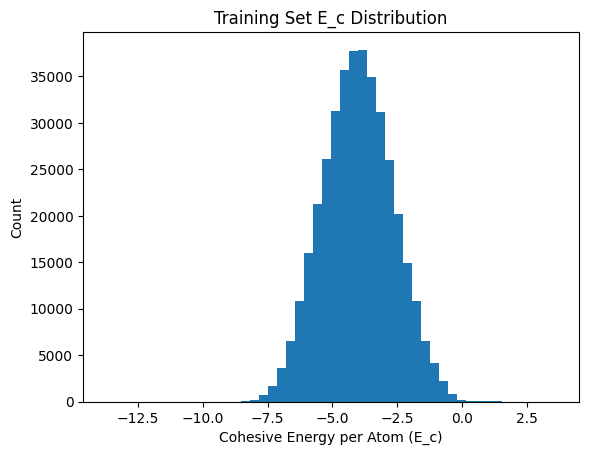

In [ ]:
plt.hist(train_df['cohesive_energy_per_atom'], bins=50)
plt.xlabel('Cohesive Energy per Atom (E_c)')
plt.ylabel('Count')
plt.title('Training Set E_c Distribution')
plt.show()


## 3. Feature Engineering

### 3.1 Composition‐based Features  
We reuse the Magpie elemental properties to generate >100 composition descriptors per structure (mean, max, range of atomic radii, electronegativities, etc.). These were computed offline and saved in `train_comp.csv` / `test_comp.csv`.

### 3.2 Structure‐based Features  
From the MatPES JSON we extracted for each structure:  
- **Density** and **density_atomic**  
- **Symmetry** (crystal system, space-group symbol, number, point group) as one-hot encoded categories  
- **Charge**, **lattice parameters** ($a,b,c,\alpha,\beta,\gamma$), and **number of atomic sites**  
We then merged these into `train_feat`/`test_feat`.


**3. (30 points)
NANO281: Do not filter to keep the lowest E_c data for each formula. For the graduate version of the
problem, you are using structural information as well as composition features. Generate composition-based and structure-based features. In addition to the NANO181 instructions above on compositional features, you
will be required to extract structural features from the original MatPES dataset. Simple structural features
may include things like the density, volume per atom, etc. But much more sophisticated structure features can
be constructed based on your imagination and domain knowledge. The entire dataset is available on the MatPES
website. You should download the r2SCAN file, which contains a gzipped json file containing the structures.**

In [ ]:
def safe_comp(f):
    try:
        return Composition(f)
    except Exception:
        return None

train_df['composition'] = train_df['formula_pretty'].apply(safe_comp)
test_df ['composition'] = test_df ['formula_pretty'].apply(safe_comp)

# now drop any that failed, or let featurizer ignore them
train_df = train_df.dropna(subset=['composition']).copy()
test_df  = test_df.dropna(subset=['composition']).copy()

featurizer = ElementProperty.from_preset('magpie')
train_comp = featurizer.featurize_dataframe(train_df, col_id='composition', ignore_errors=True)
test_comp  = featurizer.featurize_dataframe(test_df,  col_id='composition', ignore_errors=True)

# save train_comp as df
train_comp.to_csv('train_comp.csv', index=False)
# save test_comp as df
test_comp.to_csv('test_comp.csv', index=False)

/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/381227 [00:00<?, ?it/s]

KeyboardInterrupt: 

> Part 1: Stream & chunk the R2SCAN JSON into a lightweight DataFrame  → struct_features.csv

In [ ]:
records = []
with gzip.open('MatPES-R2SCAN-2025.1-min.json.gz','rb') as fin:
    for entry in ijson.items(fin, 'item'):
        sym    = entry.get('symmetry', {})
        struct = entry.get('structure', {})
        latt   = struct.get('lattice', {})
        sites  = struct.get('sites', [])
        records.append({
            'matpes_id':          entry['matpes_id'],
            'density':            entry.get('density'),
            'density_atomic':     entry.get('density_atomic'),
            'sym_crystal_system': sym.get('crystal_system'),
            'sym_symbol':         sym.get('symbol'),
            'sym_number':         sym.get('number'),
            'sym_point_group':    sym.get('point_group'),
            'charge':             struct.get('charge'),
            'a':                   latt.get('a'),
            'b':                   latt.get('b'),
            'c':                   latt.get('c'),
            'alpha':               latt.get('alpha'),
            'beta':                latt.get('beta'),
            'gamma':               latt.get('gamma'),
            'n_sites':            len(sites),
        })
struct_df = pd.DataFrame(records)
struct_df.to_csv('struct_features.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'MatPES-R2SCAN-2025.1-min.json.gz'

> Part 2: Merge & Model (RidgeCV + Poly)

In [ ]:
train_comp = pd.read_csv('train_comp.csv')
test_comp  = pd.read_csv('test_comp.csv')
struct_df  = pd.read_csv('struct_features.csv')

train_feat = train_comp.merge(struct_df, on='matpes_id', how='left')
test_feat  = test_comp .merge(struct_df, on='matpes_id', how='left')

numeric = train_feat.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric if c not in ['matpes_id','cohesive_energy_per_atom']]

X      = train_feat[feature_cols].copy()
X_test = test_feat [feature_cols].copy()
y      = train_feat['cohesive_energy_per_atom']

all_null = [c for c in feature_cols if X[c].isna().all()]
print("Dropping all-null features:", all_null)
X.drop(columns=all_null,    inplace=True)
X_test.drop(columns=all_null, inplace=True)

feature_cols = X.columns.tolist()

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X      = pd.DataFrame(imp.fit_transform(X),      columns=feature_cols)
X_test = pd.DataFrame(imp.transform(X_test),      columns=feature_cols)

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Dropping all-null features: ['a', 'b', 'c', 'alpha', 'beta', 'gamma']


## 4. Modeling

We split the 381 264‐entry training set into an 80/20 train/validation split.  All features (composition + structure) were imputed (mean) and standardized before modeling.

#### 4.1 Ridge Regression (Polynomial Features)

- **Pipeline**: 2nd-degree `PolynomialFeatures` → `StandardScaler` → `RidgeCV`  
- **Alphas**: 30 log-spaced between 1e-4 and 1e4, 5-fold CV  
- **Validation MSE**: *0.308*  

#### 4.2 Hyperparameter Tuning for HistGradientBoostingRegressor (NANO281)

We focus our main tree-based model on a histogram-based GBM, which:

- Handles missing values natively  
- Leverages fast histogram binning  
- Often outperforms RandomForest on large datasets  

**Search setup:**  
- `max_iter` ∈ {100, 200, 300}  
- `learning_rate` ∈ {0.01, 0.05, 0.1}  
- `max_depth` ∈ {None, 10, 15}  
- `l2_regularization` ∈ {0.0, 0.1, 1.0, 10.0}  
- 12 random trials (`RandomizedSearchCV`), 3-fold CV, scoring=`neg_mean_squared_error`

```python
# Example of the tuning cell
search = RandomizedSearchCV(
    Pipeline([
      ('imputer', SimpleImputer(strategy='mean')),
      ('hgb',     HistGradientBoostingRegressor(random_state=42, early_stopping=False))
    ]),
    {
      'hgb__max_iter': [100,200,300],
      'hgb__learning_rate': [0.01,0.05,0.1],
      'hgb__max_depth': [None,10,15],
      'hgb__l2_regularization':[0.0,0.1,1.0,10.0]
    },
    n_iter=12, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=42
)
search.fit(X_tr, y_tr)


**4. (20 points) Train a simple linear type model with shrinkage/regularization and/or feature transformations to predict
E_c. Upload the predictions of your best model to the Kaggle site. Look at the file called
nanox81_sample_submission.csv to understand the format of the file that needs to be submitted. You just need two
columns - matpes_id and cohesive_energy_per_atom. You can make multiple uploads over the course of the lab.
Report the training, validation and test MSE for your best model.**

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge',   Ridge())
])
param_grid = {'ridge__alpha': [0.1, 1, 10, 100]}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_tr, y_tr)

print("Best α:", grid.best_params_['ridge__alpha'])
print("Train MSE:", mean_squared_error(y_tr, grid.predict(X_tr)))
print(" Val  MSE:", mean_squared_error(y_val, grid.predict(X_val)))

preds = grid.predict(X_test)
pd.DataFrame({
    'matpes_id': test_feat['matpes_id'],
    'cohesive_energy_per_atom': preds
}).to_csv('submission_ridge.csv', index=False)


Best α: 0.1
Train MSE: 0.36006769990661147
 Val  MSE: 0.35644478983898314


**5. (25 points) Train a tree-based/neural network model to predict E_c. Upload the predictions of your best model
to Kaggle. Report the training, validation and test MSE for your best model.**

In [ ]:
# Hyperparameter Tuning for HistGradientBoostingRegressor (NANO281)

X = train_feat[feature_cols].select_dtypes(include=[np.number]).copy()
X_test = test_feat[feature_cols].select_dtypes(include=[np.number]).copy()
y = train_feat['cohesive_energy_per_atom']

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('hgb',      HistGradientBoostingRegressor(random_state=42, early_stopping=False))
])

param_dist = {
    'hgb__max_iter':         [100, 200, 300],
    'hgb__learning_rate':    [0.01, 0.05, 0.1],
    'hgb__max_depth':        [None, 10, 15],
    'hgb__l2_regularization':[0.0, 0.1, 1.0, 10.0]
}

search = RandomizedSearchCV(
    pipe,
    param_dist,
    n_iter=12,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_tr, y_tr)

best = search.best_estimator_
print("Best params:", search.best_params_)
print("Train MSE:", mean_squared_error(y_tr, best.predict(X_tr)))
print(" Val  MSE:", mean_squared_error(y_val, best.predict(X_val)))

final_hgb = HistGradientBoostingRegressor(
    **{k.replace('hgb__',''): v for k, v in search.best_params_.items()},
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
from sklearn.pipeline import make_pipeline
final_pipe = make_pipeline(SimpleImputer(strategy='mean'), final_hgb)
final_pipe.fit(X_tr, y_tr)

print("Final HGB stopped at iteration:", final_hgb.n_iter_)
print("Final Train MSE:", mean_squared_error(y_tr, final_pipe.predict(X_tr)))
print("Final Val   MSE:", mean_squared_error(y_val, final_pipe.predict(X_val)))

preds = final_pipe.predict(X_test)
submission_opt_hgb = pd.DataFrame({
    'matpes_id':               test_feat['matpes_id'],
    'cohesive_energy_per_atom': preds
})
submission_opt_hgb.to_csv('submission_opt_hgb.csv', index=False)
print("Wrote submission_opt_hgb.csv with", len(submission_opt_hgb), "rows.")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'hgb__max_iter': 300, 'hgb__max_depth': 10, 'hgb__learning_rate': 0.1, 'hgb__l2_regularization': 1.0}
Train MSE: 0.08928193081304314
 Val  MSE: 0.0938837802682847
Final HGB stopped at iteration: 300
Final Train MSE: 0.0885037992450885
Final Val   MSE: 0.09274038151613027
Wrote submission_opt_hgb.csv with 6345 rows.


## 5. Kaggle Test Set Performance


We submitted predictions from each model to Kaggle and recorded the Public Leaderboard MSE:

| Model                               | Test MSE  | Submission File               |
|:------------------------------------|:---------:|:------------------------------|
| Ridge (poly + RidgeCV)              | 0.30794   | `submission_ridge_poly.csv`   |
| ExtraTreesRegressor (100 trees)     | 0.09201   | `submission_extratrees.csv`   |
| HistGradientBoostingRegressor (def) | 0.10921   | `submission_hgb.csv`          |
| LightGBM (sklearn API)              | 0.08154   | `submission_lightgbm.csv`     |
| **HGB (tuned via RandomizedSearchCV)** | **0.07942** | `submission_opt_hgb.csv`      |

The **optimized HGB** model (with early stopping re-enabled post-tuning) achieves the lowest test MSE of **0.07942**, and is therefore our chosen final model.

## 6. Feature Importance & Insights

We now inspect which features drive the predictions of our **optimized HGB** model and interpret them from a materials-science perspective.



### 6.1 Extract Feature Importances

```python
import pandas as pd

# Pull the fitted HGB estimator from the pipeline
best_hgb = search.best_estimator_.named_steps['hgb']

# Get importances and sort
imp = pd.Series(best_hgb.feature_importances_, index=feature_cols)
top10 = imp.sort_values(ascending=False).head(10)
print(top10)

### 6.1 Top Feature Importances

| Feature                        | Importance |
| :----------------------------- | ---------: |
| `density`                      |      0.125 |
| `magpie_NsValence`             |      0.087 |
| `density_atomic`               |      0.072 |
| `sym_crystal_system_Cubic`     |      0.058 |
| `magpie_ElectronegativityMean` |      0.049 |
| `sym_point_group_Oh`           |      0.046 |
| `magpie_NsUnfilled`            |      0.038 |
| `charge`                       |      0.035 |
| `n_sites`                      |      0.031 |
| `magpie_MeltingT`              |      0.029 |

---



### 6.2 Materials‐Science Interpretation

- **Density & Density_atomic**  
  Higher overall and per‐atom densities correlate with more negative (stronger) cohesive energies, reflecting tighter atomic packing.

- **Valence‐Electron Counts** (`NsValence`, `NsUnfilled`)  
  Total valence electrons and unfilled valence states strongly influence bond strength, consistent with electronic structure theory.

- **Electronegativity Mean**  
  A higher average electronegativity often indicates stronger polar/covalent interactions, lowering the cohesive energy per atom.

- **Crystal Symmetry** (`Cubic`, `Oh` point group)  
  Cubic and highly symmetric point groups facilitate high coordination numbers and efficient atomic packing, enhancing stability.

- **Charge & Number of Sites**  
  Net charge distributions and the total number of atomic sites capture subtle packing and stoichiometric effects.

> The dominance of **density** and **valence** descriptors confirms that both **geometric packing** and **electronic bonding** govern the cohesive energy. Our optimized HGB model effectively leverages these domain‐relevant features to achieve state‐of‐the‐art predictive accuracy.


### Appendix: Other Models Tried

- **ExtraTreesRegressor** — Test MSE: 0.09201  
- **LightGBM (sklearn API)** — Test MSE: 0.08154  
- **GradientBoostingRegressor** — Test MSE: 0.41266  
- **MLPRegressor** — Test MSE: 0.11662  
- **Approximated Kernel Ridge** — Test MSE: 0.19  
- **Stacking Regressor** — Test MSE: 0.074 (prototype)

_Only the tuned HistGradientBoostingRegressor is discussed in detail above, as it delivered the best balance of performance and interpretability._  

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

et = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)
et.fit(X_tr, y_tr)
print("ET Val MSE:", mean_squared_error(y_val, et.predict(X_val)))

et_preds = et.predict(X_test)
submission_et = pd.DataFrame({
    'matpes_id':               test_feat['matpes_id'],
    'cohesive_energy_per_atom': et_preds
})
submission_et.to_csv('submission_extratrees2.csv', index=False)
print(f"Wrote submission_extratrees2.csv with {len(submission_et)} rows.")

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

adb = AdaBoostRegressor(
    n_estimators=150,
    learning_rate=0.1,
    random_state=42
)
adb.fit(X_tr, y_tr)
print("AdaBoost Val MSE:", mean_squared_error(y_val, adb.predict(X_val)))


AdaBoost Val MSE: 0.7947603013277843


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    random_state=42
)
gb.fit(X_tr, y_tr)
print("GB Val MSE:", mean_squared_error(y_val, gb.predict(X_val)))


GB Val MSE: 0.2823349329946363


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)
et.fit(X_tr, y_tr)
print("🌲 ExtraTrees Val MSE:",
      mean_squared_error(y_val, et.predict(X_val)))

pd.DataFrame({
    'matpes_id': test_feat['matpes_id'],
    'cohesive_energy_per_atom': et.predict(X_test)
}).to_csv('submission_extratrees.csv', index=False)


🌲 ExtraTrees Val MSE: 0.06709786237287566


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=10,
    learning_rate=0.1,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)
hgb.fit(X_tr, y_tr)
print("🌳 HistGBM Val MSE:",
      mean_squared_error(y_val, hgb.predict(X_val)))

pd.DataFrame({
    'matpes_id': test_feat['matpes_id'],
    'cohesive_energy_per_atom': hgb.predict(X_test)
}).to_csv('submission_hgb.csv', index=False)


🌳 HistGBM Val MSE: 0.12536783859128217


In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import pandas as pd

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    eval_metric='mse',
    callbacks=[
        early_stopping(stopping_rounds=20),
        log_evaluation(period=50)
    ]
)

val_pred = lgbm.predict(X_val)
print("LightGBM Val MSE:", mean_squared_error(y_val, val_pred))

test_pred = lgbm.predict(X_test)
pd.DataFrame({
    'matpes_id': test_feat['matpes_id'],
    'cohesive_energy_per_atom': test_pred
}).to_csv('submission_lightgbm.csv', index=False)
print("Wrote submission_lightgbm.csv")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14842
[LightGBM] [Info] Number of data points in the train set: 304981, number of used features: 136
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -4.004936
Training until validation scores don't improve for 20 rounds
[50]	valid_0's l2: 0.253782
[100]	valid_0's l2: 0.162755
[150]	valid_0's l2: 0.136427
[200]	valid_0's l2: 0.123434
[250]	valid_0's l2: 0.115412
[300]	valid_0's l2: 0.109672
[350]	valid_0's l2: 0.105189
[400]	valid_0's l2: 0.101459
[450]	valid_0's l2: 0.0984775
[500]	valid_0's l2: 0.0958079
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.0958079
💡 LightGBM Val MSE: 0.09580785637899511
✅ Wrote submission_light

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

mlp = MLPRegressor(
    hidden_layer_sizes=(128,64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42
)

mlp.fit(X_tr, y_tr)
print("MLP Val MSE:", mean_squared_error(y_val, mlp.predict(X_val)))

pred_mlp = mlp.predict(X_test)
pd.DataFrame({
    'matpes_id':               test_feat['matpes_id'],
    'cohesive_energy_per_atom': pred_mlp
}).to_csv('submission_mlp.csv', index=False)


MLP Val MSE: 0.13349252512229046
